<a href="https://www.kaggle.com/code/codemaster69/intro-to-ml-logistic-regression-w-pytorch?scriptVersionId=159412242" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Hello! Here's what you can expect to see in this notebook.

We explore the A-Z of one the methods behind binary classification in this notebook – Logistic Regression. You'll learn what "logisitc regression" is, the motivation behind it, how ML models are trained, and more. What follows is not a table of contents. Rather, it's more of a map detailing the flow of this notebook.

* What is Logisitc Regression, and how does it work?

* How do ML models learn, and how can we train them?
    * The Forward Pass
    * Back Propagation
    * Stochastic Gradient Descent


* A PyTorch demo of Logisitc Regression

### How does Logistic Regression work?

Consider you have a problem with two input variables (`x, y`) that are continous (can be anything from negative infinity to positive infinty), and single output variable (`z`) that's discrete, and has values either `red` or `blue`. Your data looks something like this:

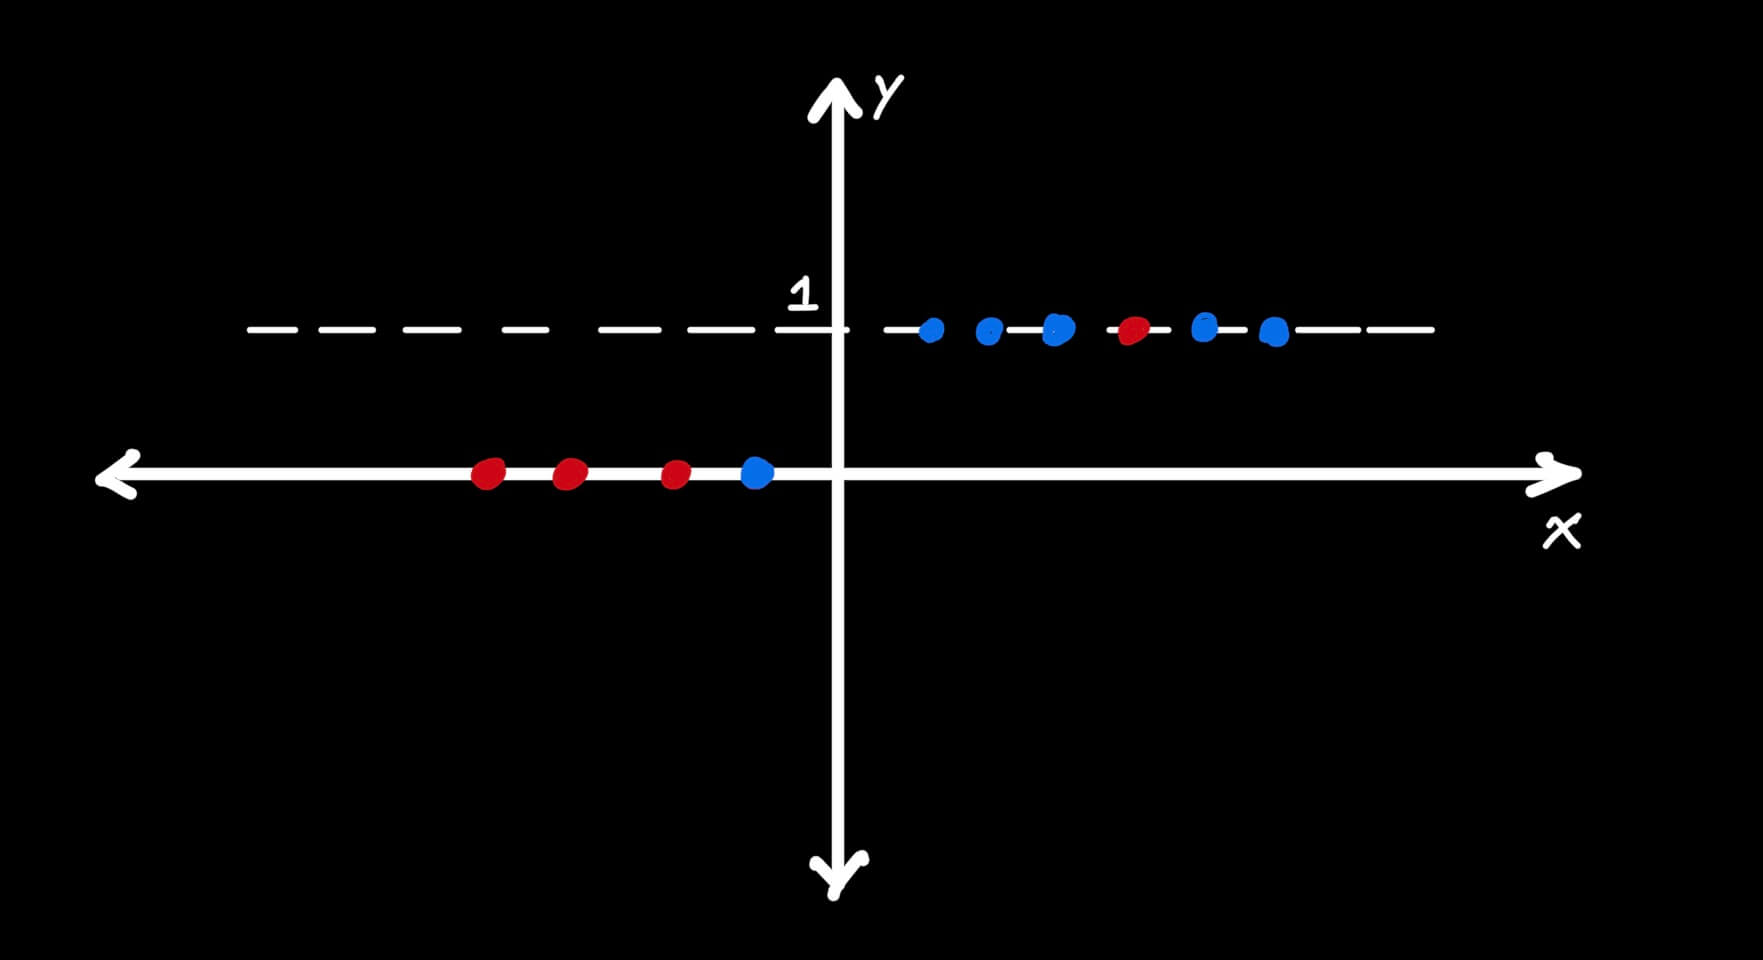

Our challenge is to estimate a function that will allow us to predict what the color of a new dot will be based on its x and y values. The function will accept the new dot's `x` and `y` values, and let us know if the dot is supposed to `blue` or `red`.

**A linear line doesn't seem to do the job very well, even if it's shifted (as this one is).**

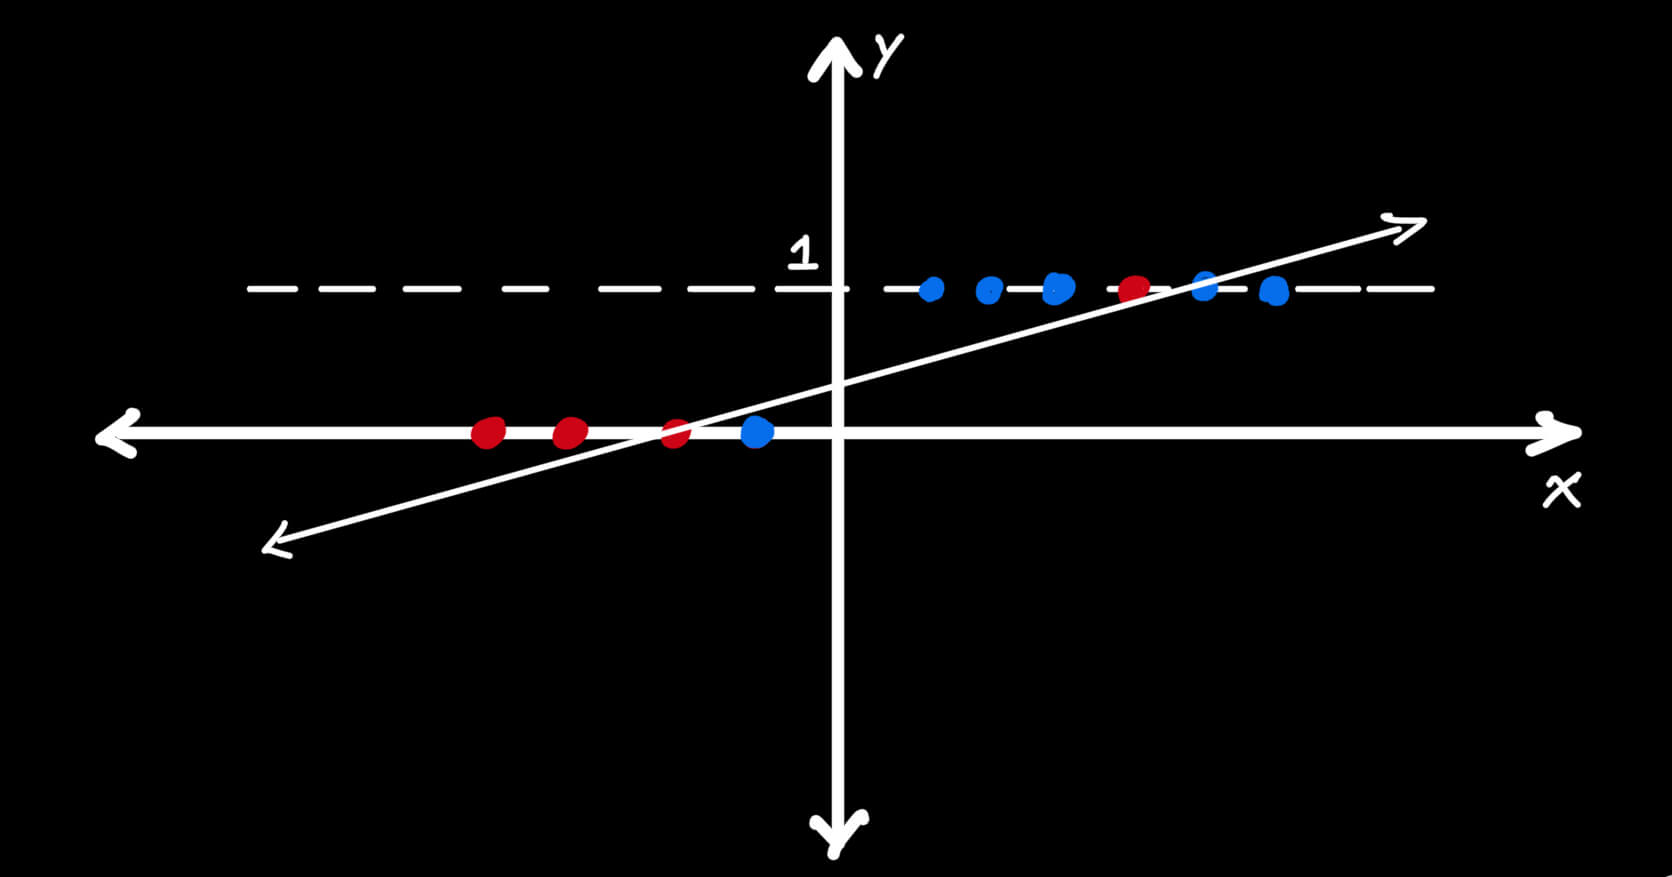

**But what if we had a function that looked more like this?**

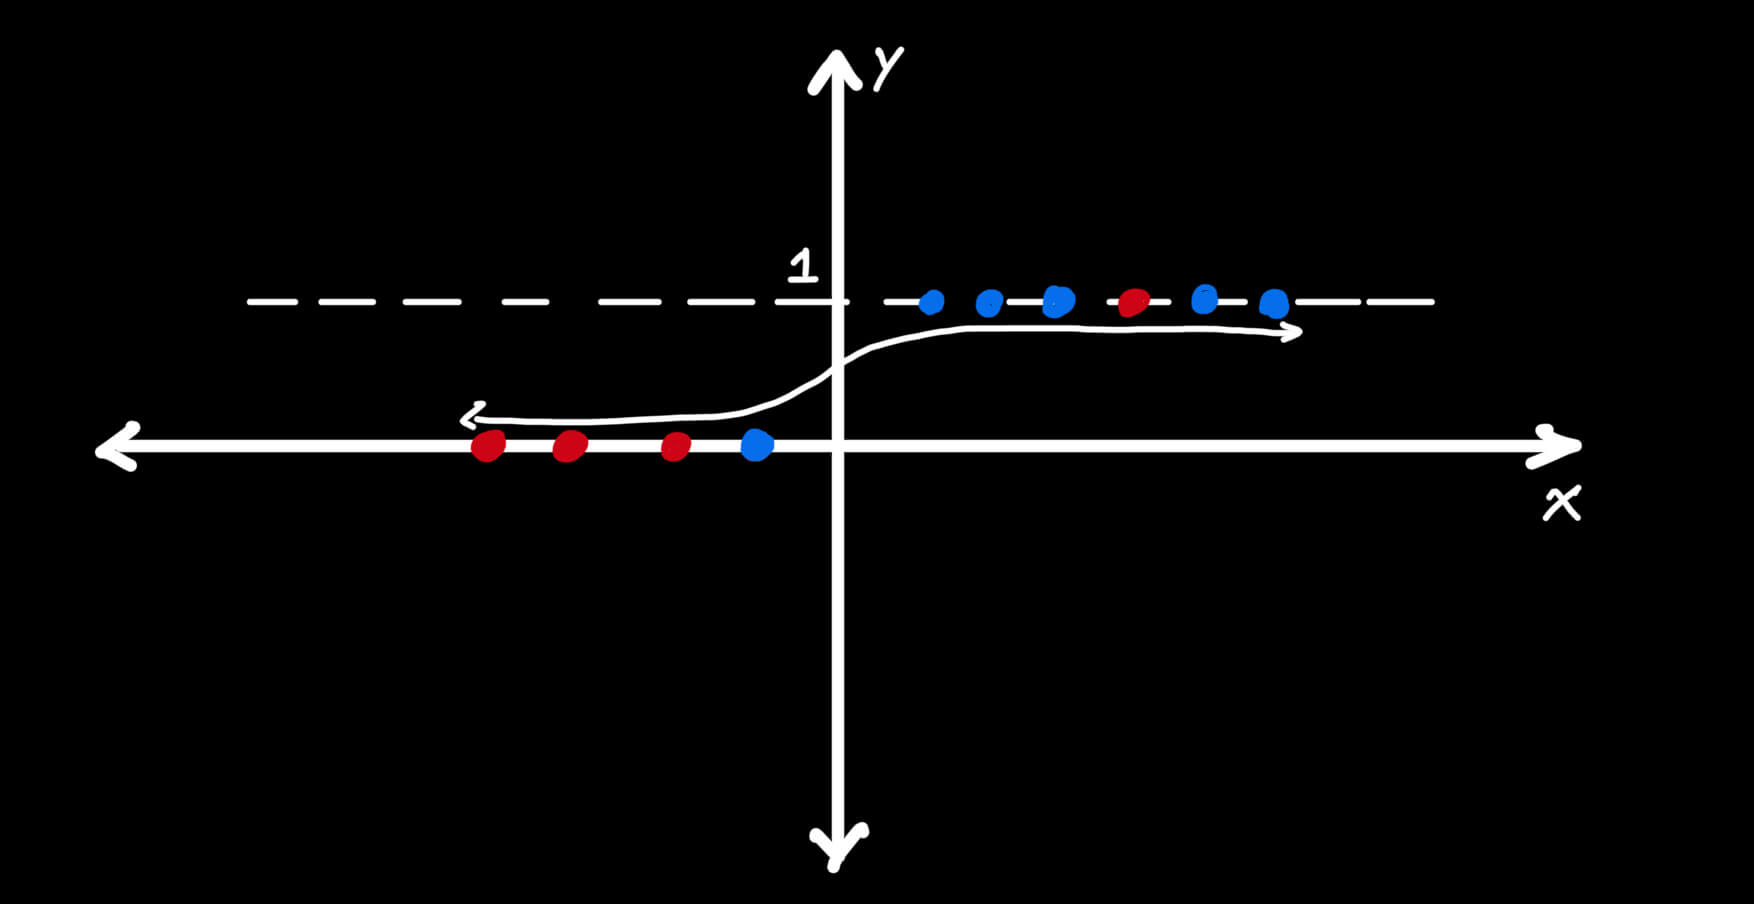


Our world is 3D, since we have three variables is x, y, and z = color. In a 2D world, that's the function defined by this formula:

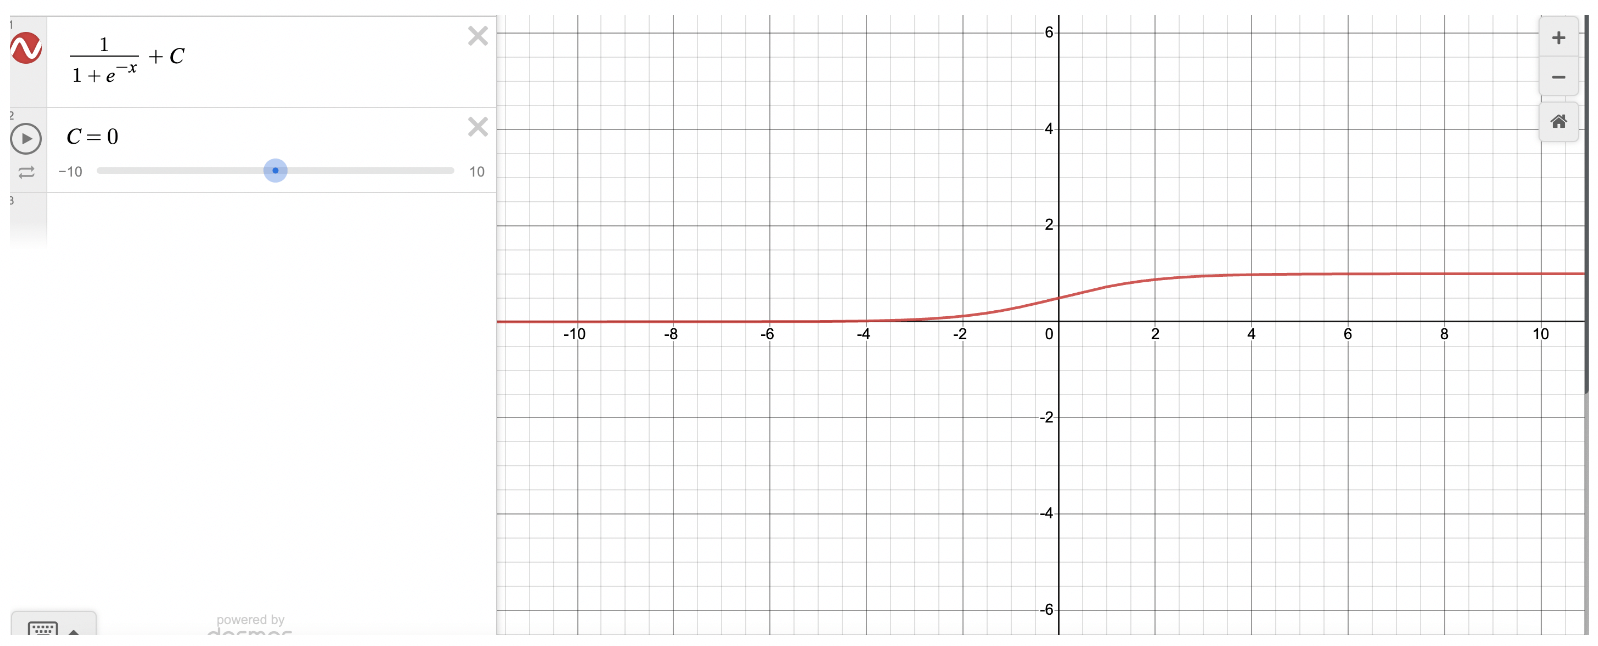

That's called the **Sigmoid Function**.

And with logistic regression, what we're basically trying to do is understand how much the function should curve (aka how steep the function should be), how much it should be shifted by, etc. 

In a world where the output variable (the "color" of the dot) is predicted by multiple variables, the steepness, the shift, of our function would vary with respect to the different variables differently. If we were doing this manually, our job with logisitic regression is to figure out how they vary, and how we can use that to estimate the color of a new dot.

But the good news is – we aren't doing this manually! That estimation that we spoke of is what we're going to be writing code to do :)

Before we get to the next section, let us write some code and take a look at our dataset.

In [1]:
import pandas as pd
import numpy as np

# A variable to make our lives a little easier
TRAIN_CSV_PATH = "/kaggle/input/heart-disease-prediction-using-logistic-regression/framingham.csv"

In [2]:
df = pd.read_csv(TRAIN_CSV_PATH)
df.head(5)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [3]:
df.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4238.000000,4238.000000,4133.000000,4238.000000,4209.000000,4185.000000,4238.000000,4238.000000,4238.000000,4188.000000,4238.000000,4238.000000,4219.000000,4237.000000,3850.000000,4238.000000
mean,0.429212,49.584946,1.978950,0.494101,9.003089,0.029630,0.005899,0.310524,0.025720,236.721585,132.352407,82.893464,25.802008,75.878924,81.966753,0.151958
std,0.495022,8.572160,1.019791,0.500024,11.920094,0.169584,0.076587,0.462763,0.158316,44.590334,22.038097,11.910850,4.080111,12.026596,23.959998,0.359023
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,89.875000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


In [4]:
num_records = len(df)
print(f"\nNumber of records: {num_records}")

columns = list(df.columns)
print("\nAttributes:\n")
num_max_categories_in_a_column = 5
continuous_attributes = list()

for column in columns:
    if (len(df[column].unique()) <= num_max_categories_in_a_column):
        values = str(df[column].unique())
        print(column + ": " + values)
    else:
        print(column + ": continuous")
        continuous_attributes.append(column)


Number of records: 4238

Attributes:

male: [1 0]
age: continuous
education: [ 4.  2.  1.  3. nan]
currentSmoker: [0 1]
cigsPerDay: continuous
BPMeds: [ 0.  1. nan]
prevalentStroke: [0 1]
prevalentHyp: [0 1]
diabetes: [0 1]
totChol: continuous
sysBP: continuous
diaBP: continuous
BMI: continuous
heartRate: continuous
glucose: continuous
TenYearCHD: [0 1]


We chose the number 5 above since that was the maximum number of classes among categorical variables in this dataset. You can verify this by going through the data card, or by printing out all unique values for all columns.

Logisitc regression models are sensitive to the range that attributes are spread across, especially if different attributes have wildly different ranges. To tackle this problem, let us normalize all continuous attributes to be centered around their mean.

In [5]:
for column in continuous_attributes:
    df[column] = (df[column] - df[column].mean())/df[column].std()

In [6]:
df.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4238.000000,4.238000e+03,4133.000000,4238.000000,4.209000e+03,4185.000000,4238.000000,4238.000000,4238.000000,4.188000e+03,4.238000e+03,4.238000e+03,4.219000e+03,4.237000e+03,3.850000e+03,4238.000000
mean,0.429212,1.332896e-16,1.978950,0.494101,-6.921419e-17,0.029630,0.005899,0.310524,0.025720,3.113290e-16,-4.560350e-16,2.984347e-16,7.241843e-17,3.353990e-18,1.790199e-16,0.151958
std,0.495022,1.000000e+00,1.019791,0.500024,1.000000e+00,0.169584,0.076587,0.462763,0.158316,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.359023
min,0.000000,-2.051402e+00,1.000000,0.000000,-7.552867e-01,0.000000,0.000000,0.000000,0.000000,-2.909186e+00,-2.216725e+00,-2.929553e+00,-2.515129e+00,-2.650702e+00,-1.751534e+00,0.000000
25%,0.000000,-8.848348e-01,1.000000,0.000000,-7.552867e-01,0.000000,0.000000,0.000000,0.000000,-6.889741e-01,-6.966303e-01,-6.627121e-01,-6.695915e-01,-6.551250e-01,-4.577109e-01,0.000000
50%,0.000000,-6.823785e-02,2.000000,0.000000,-7.552867e-01,0.000000,0.000000,0.000000,0.000000,-6.103532e-02,-1.974947e-01,-7.501261e-02,-9.852859e-02,-7.308167e-02,-1.655573e-01,0.000000
75%,1.000000,7.483591e-01,3.000000,1.000000,9.225524e-01,0.000000,0.000000,1.000000,0.000000,5.893298e-01,5.285208e-01,5.861493e-01,5.485126e-01,5.921107e-01,2.100687e-01,0.000000
max,1.000000,2.381553e+00,4.000000,1.000000,5.117150e+00,1.000000,1.000000,1.000000,1.000000,1.029995e+01,7.380292e+00,5.004390e+00,7.597340e+00,5.581053e+00,1.302309e+01,1.000000


We now see that all continuous columns have been normalized. Let us now set all NaN values, across columns, to -1.

In [7]:
for column in df.columns:
    df[column] = df[column].fillna(-1)
df.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4238.000000,4.238000e+03,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4.238000e+03,4.238000e+03,4238.000000,4238.000000,4238.000000,4238.000000
mean,0.429212,1.332896e-16,1.905144,0.494101,-0.006843,0.016753,0.005899,0.310524,0.025720,-0.011798,-4.560350e-16,2.984347e-16,-0.004483,-0.000236,-0.091553,0.151958
std,0.495022,1.000000e+00,1.108453,0.500024,0.999977,0.203701,0.076587,0.462763,0.158316,0.999930,1.000000e+00,1.000000e+00,0.999990,1.000000,0.995799,0.359023
min,0.000000,-2.051402e+00,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,-2.909186,-2.216725e+00,-2.929553e+00,-2.515129,-2.650702,-1.751534,0.000000
25%,0.000000,-8.848348e-01,1.000000,0.000000,-0.755287,0.000000,0.000000,0.000000,0.000000,-0.711400,-6.966303e-01,-6.627121e-01,-0.674493,-0.655125,-0.582920,0.000000
50%,0.000000,-6.823785e-02,2.000000,0.000000,-0.755287,0.000000,0.000000,0.000000,0.000000,-0.083462,-1.974947e-01,-7.501261e-02,-0.103430,-0.073082,-0.207294,0.000000
75%,1.000000,7.483591e-01,3.000000,1.000000,0.922552,0.000000,0.000000,1.000000,0.000000,0.566903,5.285208e-01,5.861493e-01,0.547900,0.592111,0.126596,0.000000
max,1.000000,2.381553e+00,4.000000,1.000000,5.117150,1.000000,1.000000,1.000000,1.000000,10.299954,7.380292e+00,5.004390e+00,7.597340,5.581053,13.023091,1.000000


## How do ML models learn?

In general, models see an example with all its different parameters, they input all those different parameters into a function and pull out a prediction for the target value. This is called the **forward pass**. 

Then, they measure the difference between the predicted target value and the true target value (**computing the loss**). 

Based on the loss, the network adjusts the function it uses in a process called the **backward pass**. This is how all models, in general, learn to predict the target value with a reasonable degree of correctness.

But what does the function look like? What does the model adjust about the said function, and how does it do so? Let us dive deeper into these questions in the context of Logisitic Regression.

### How Models Learn: The Logistic Regression Context

Say we now have a scenario where we have 3 input variables, `x_1`, `x_2`, and `x_3`, and a parameter to shift our function, `C` (remember the image of the graph from before?). This is what our inputs look like:

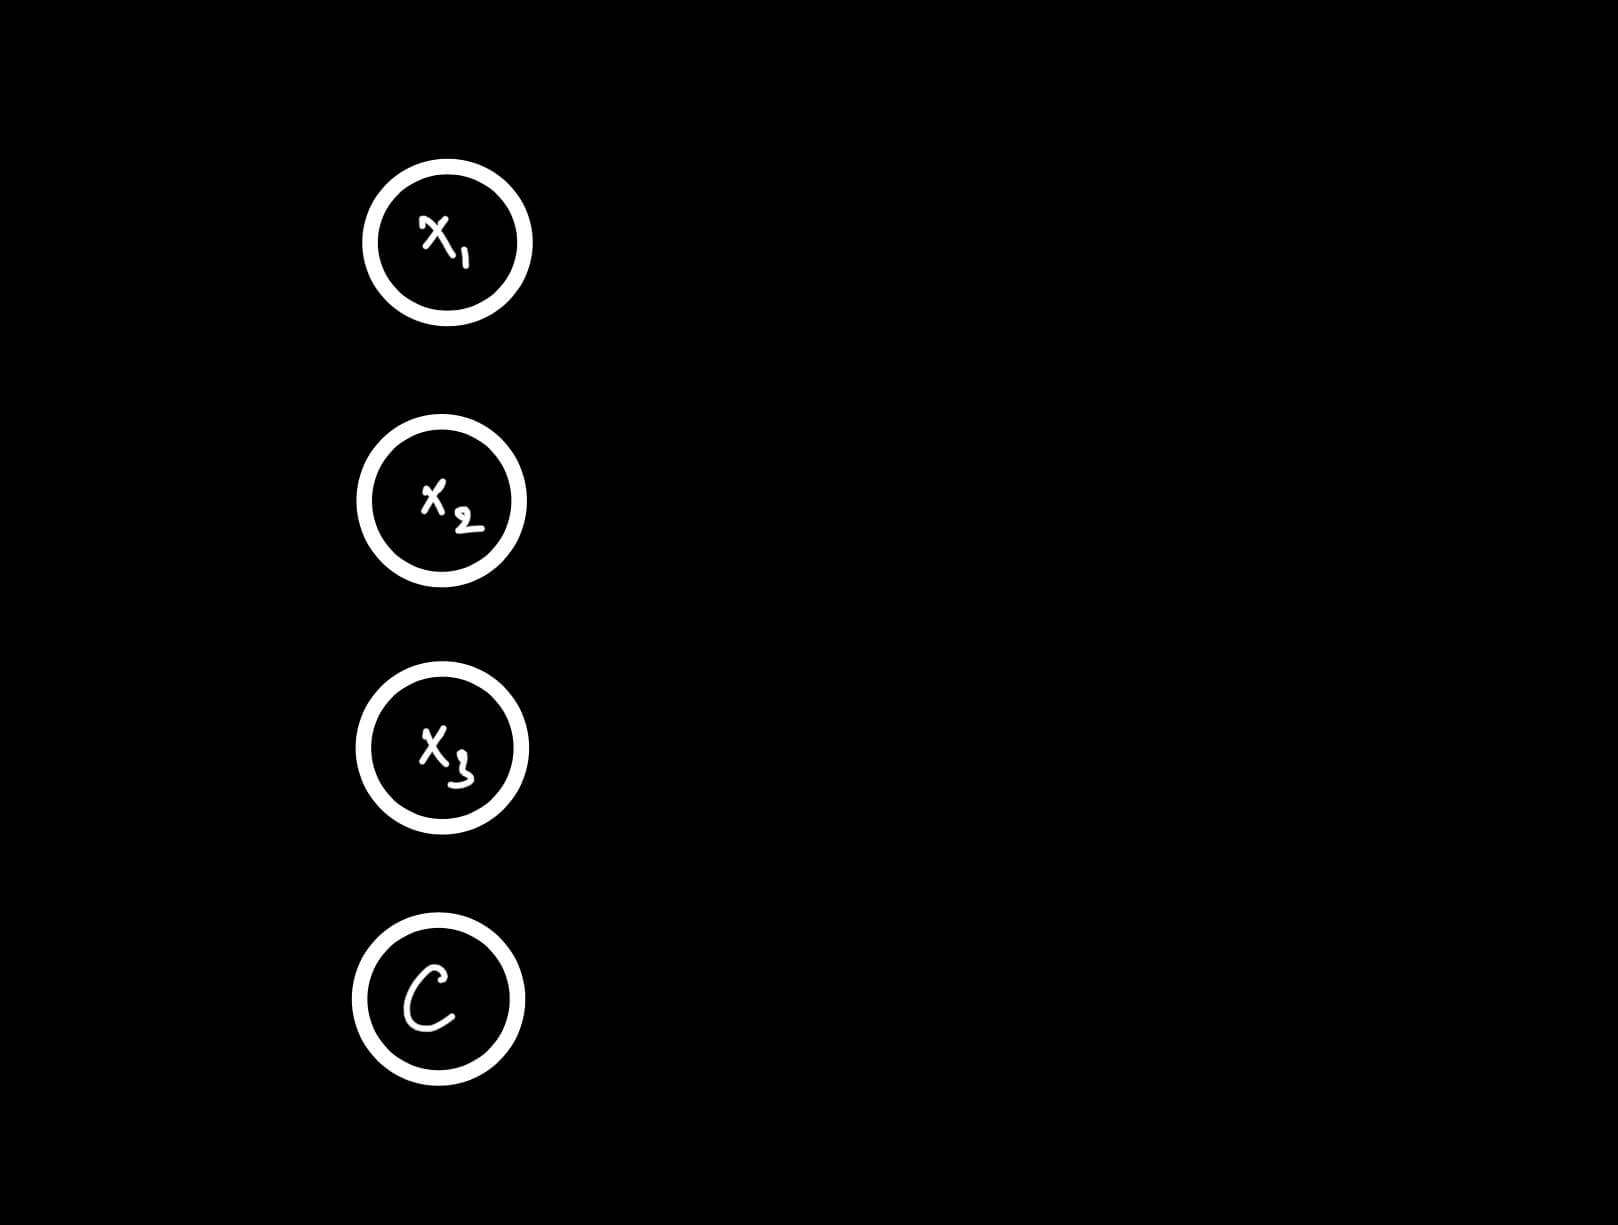

Remember, each of these inputs have varying degrees of relevance to the output. This degree of relevance is captured by weighting all these inputs differenly when we pass it into the function that estimates our output. 

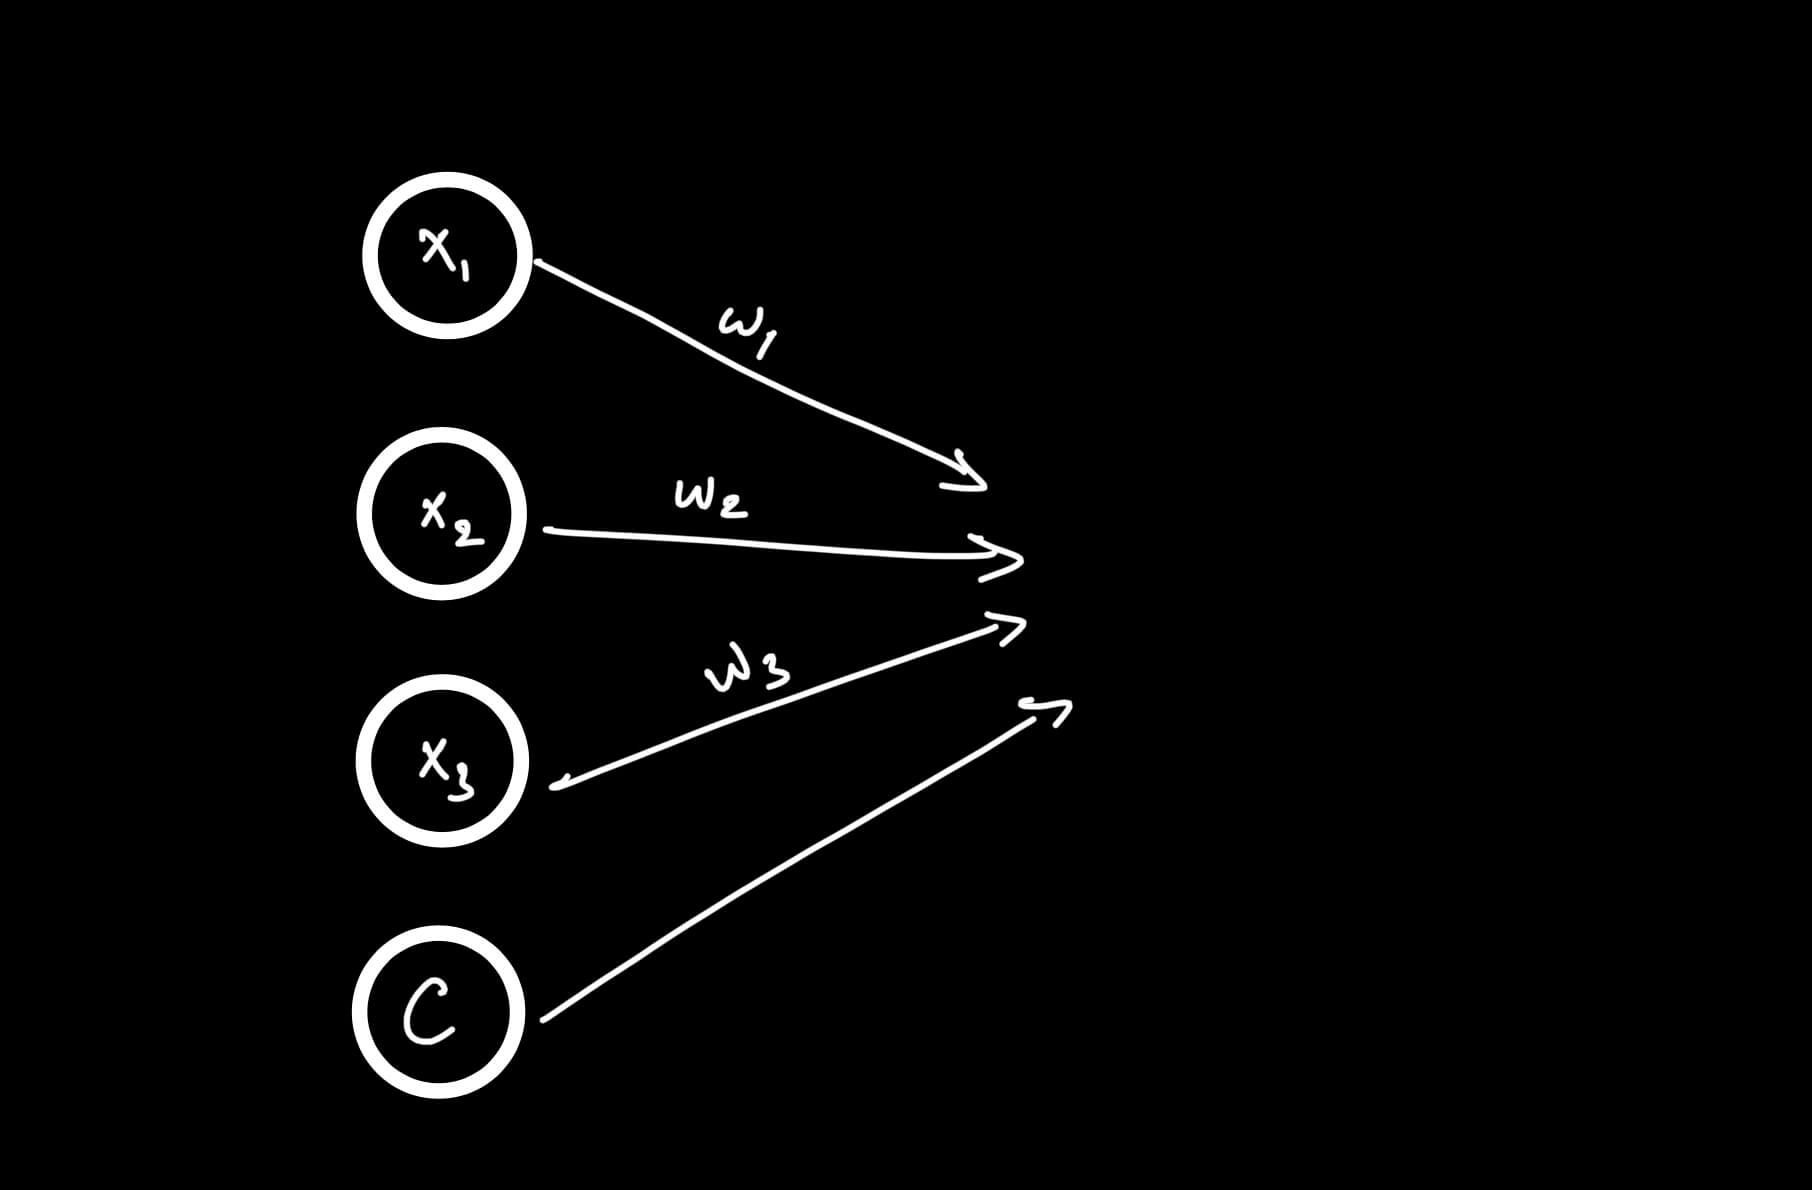

The shift parameter `C` – also called the **bias** – doesn't have any weight associated with it since we can modify it directly (unlike the other input parameters).

Those arrows above lead into a summation unit, which multiplies all the inputs by their respective weights and yields their sum with the bias. This is then fed into the **Sigmoid Function**, which then yields a final output – the prediction, represented by `y_hat`.

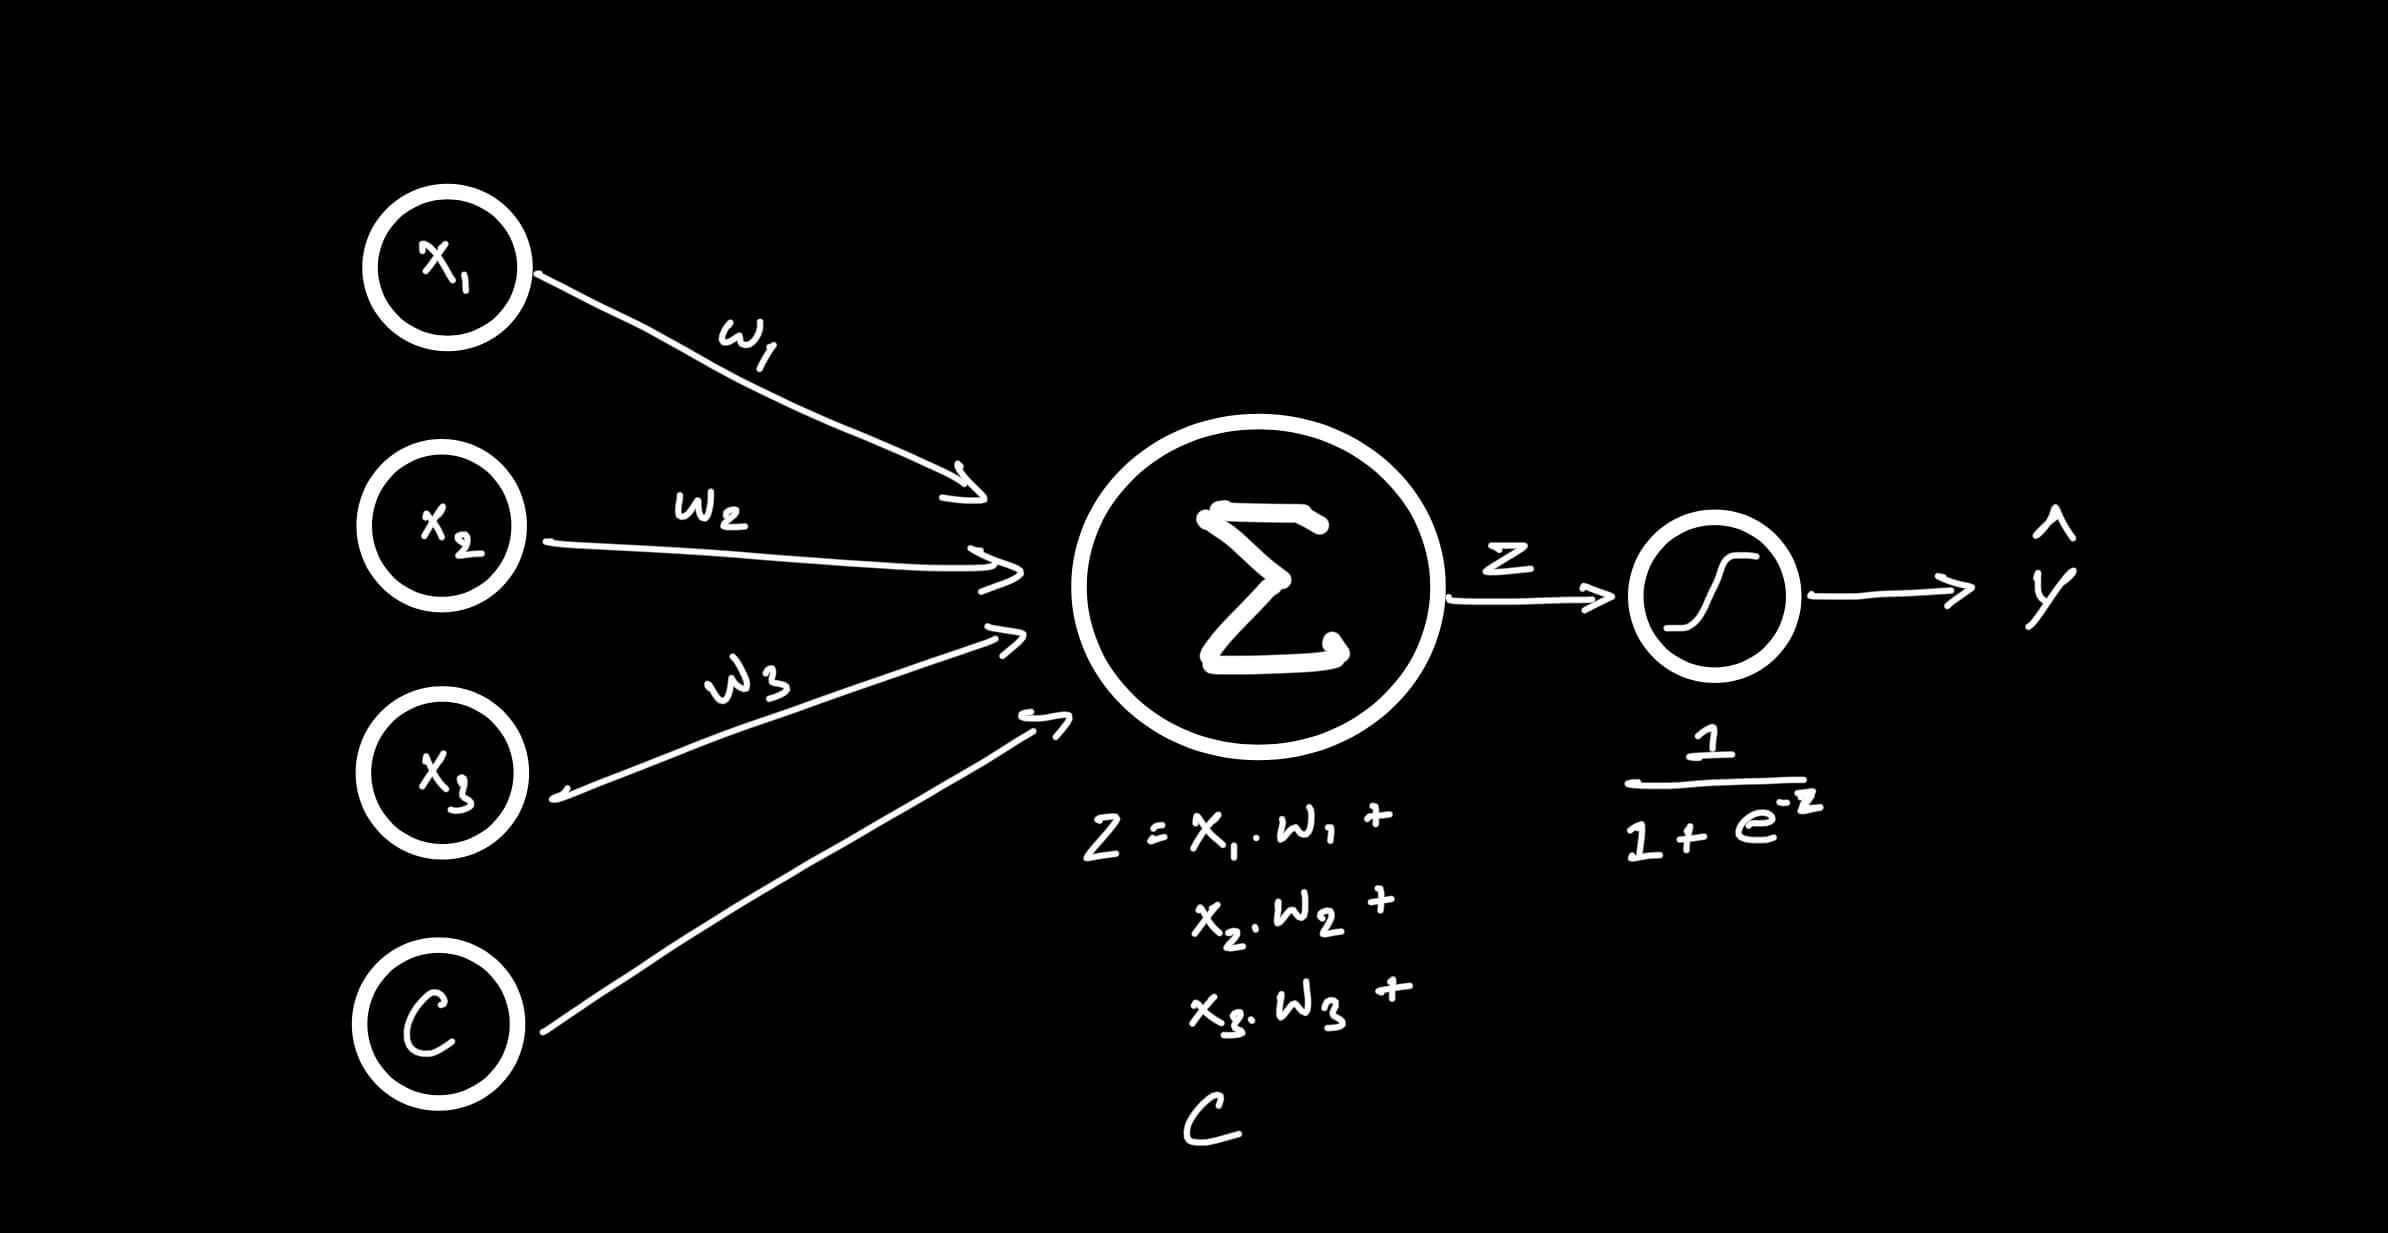

Let's write some code to bring this model to reality.

In [8]:
import torch
import torch.nn as nn

# You'll see what this is for later
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Helper library
from tqdm import tqdm

# Helper variable
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu"),  # 🧭 Device for training (GPU if available, else CPU)

In [9]:
class LogisticRegModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # We take input_dim inputs and get 8 different outputs
        self.input_layer = nn.Linear(input_dim, 1)
        
        # We'll add an extra layer between the input layer and the summation unit 
        # so that we have more trainable parameters. 
        # But don't worry about this too much – all it does it add more weights to the mix, 
        # so that our model has trainable parameters 
        # (that's what the weights are called)
        
        # we take 8 inputs from the previous layer and yield 1 output, which is
        # summation z from the diagram
        
        
    def forward(self, x):
        x = self.input_layer(x)
        y_hat = torch.sigmoid(x)
        
        return y_hat
    
model = LogisticRegModel(len(df.columns)-1).to(DEVICE[0])

### Updating Weights

Then, how would we update the weights to improve our prediction?

We first measure the difference between our actual label `y`, and our predicted label `y_hat` using the **loss function** `L(y_hat, y)` (we'll come back to this later). Our objective is to minimize the loss function (since that'll allow us to make the most accurate predictions). 

Then, we compute how the loss function varies with each individual weight using partial derivatives. Recall from calculus that the gradient of a function (the collection of its partial derivatives w.r.t all input variables) gives the direct of steepest ascent, i.e. the route to mazimize the function. 

But we want to minimize the loss function – therefore, it makes sense that we should be moving in the direction opposite to the gradient. AKA, the direction of the negative gradient.

So, we update each individual weight in the following way.

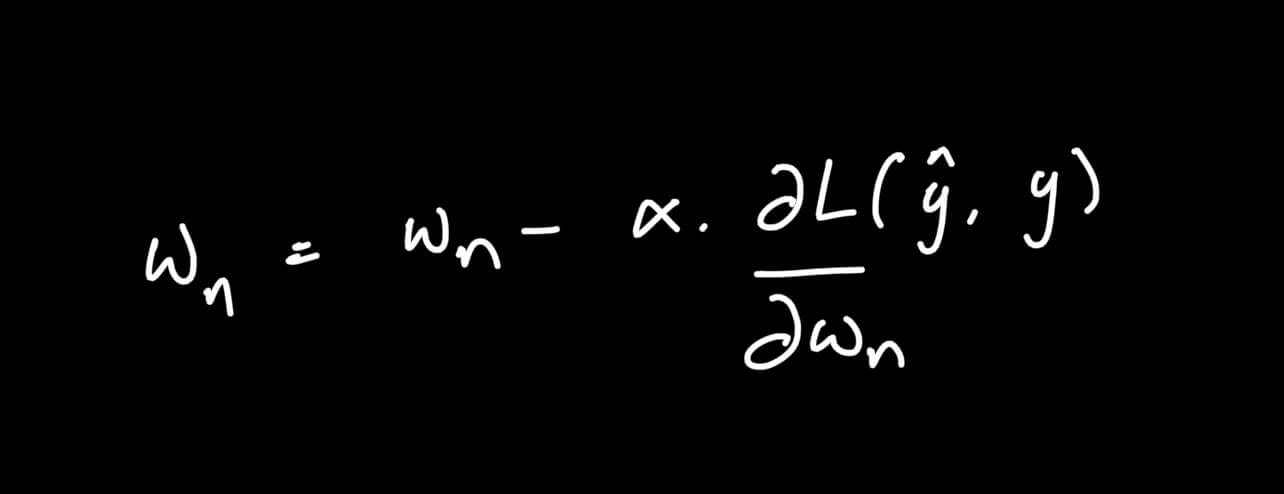

What's the `alpha`, you ask? It's called the **Learning Rate** – a coefficient (common to all distinct weights) that allows to decide how much significance we want to give to the gradient. By setting it to `0`, for example, we're deciding that we never want to update our weights. 

But there's a problem: updating our weights too often, with every input instance we see, for example, might not allow our model to generalize very well. At the same time, updating our weights too infrequently barely allows the model to learn. 

So we need to strike a balance, and that is precisely what **optimizers** allow us to do. Batch gradient descent, for example takes the average of the gradient every `n` samples (also called `batch_size`), and updates the weights with the above-mentioned average gradient. 

There are other, different kinds of optimizers, but in this notebook, we'll specifically focus on **SGD**, or **S**tochastic **G**radient **D**escent. Instead of computing the gradient over the entire dataset or for every example, **SGD** picks one example at random in a batch, and updates weights using the gradients computed w.r.t the loss for that example.

### The Loss Function

While this can be a simple squared difference measure for problems where we need to predict continous values, we typically use something called the Binary Cross Entropy Loss for Logistic Regression.

It's defined as follows:

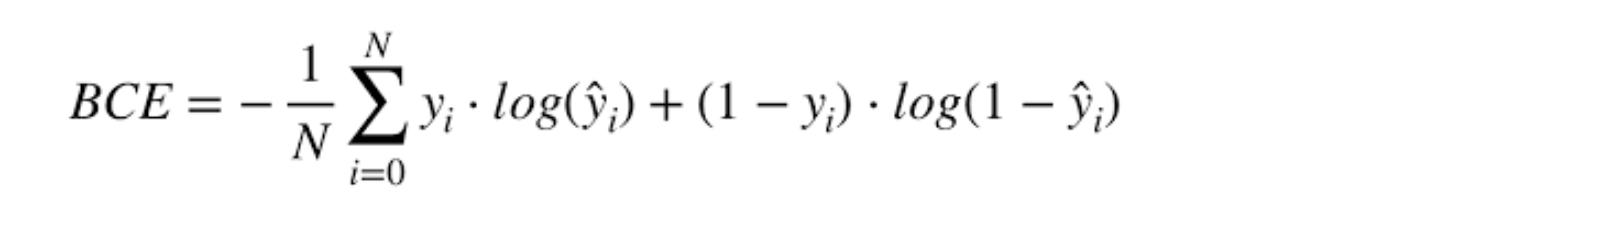

Consider the possible outcomes in classification problems: the model gets it right, or it doesn't. In binary classification, that means the following:

1. The correct class is `0`, and the model predicts `0`.
2. The correct class is `1`, and the model predicts `1`.

OR 

3. The correct class is `0`, but the model predicts `1`.
4. The correct class is `1`, but the model predicts `0`.

In practice, a value of `epsilon` is added to the argument of the log term to avoid taking the log of `0`. We'll ignore that here, and assume for simplicity's sake that `log(0)` term is irrelevant, since it will always be multiped by a `0`.

See [here](https://towardsdatascience.com/understanding-pytorch-loss-functions-the-maths-and-algorithms-part-2-104f19346425) for an explanation. Here's [another](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) great explanation.

Let's write some code now, to define the `loss` and the `optimizer`.

In [10]:
learning_rate = 1e-3 # Learning rate, or the "alpha" from earlier
batch_size = 32 # this is number of samples after which we update our weights
epochs = 50 # this is the number of times we run through our entire dataset

In [11]:
criterion = nn.BCELoss() # the loss we talked about
optimizer = optim.SGD(model.parameters(), lr = learning_rate) # stochastic gradient descent

In [12]:
class CHDDataset(Dataset):
    def __init__(self, dataset: pd.DataFrame):
        self.data = dataset
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        record_at_idx = dict(self.data.loc[idx])
        input_attributes = []
        label = None
        for key in record_at_idx.keys():
            if key != "TenYearCHD":
                input_attributes.append(float(record_at_idx[key]))
            else:
                label = int(record_at_idx[key])
                
        sample = {"inputs": np.array(input_attributes), "label": label}
        
        return sample

In [13]:
train_dataset = CHDDataset(df)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size)

In [14]:
losses = list()
num_iters = 0
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}:")
    for batch in tqdm(train_dataloader):
        inputs, labels = batch["inputs"], batch["label"]
        inputs = inputs.to(DEVICE[0], dtype = torch.float32)
        labels = labels.to(DEVICE[0], dtype = torch.float32)
        
        # The Forward Pass – we pass the inputs to the model, 
        # and get the model's predictions as the output.
        outputs = model(inputs) # Shape of outputs is [16, 1]
        outputs = torch.squeeze(outputs, dim = 1) # With this line, we change the shape to [16]
        
        # Computing the loss – we measure how far off we are.
        
        loss = criterion(outputs, labels)
        losses.append(loss)
        
        # Backpropagation – we update our weights
#         optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        num_iters += 1

Epoch 1/50:


100%|██████████| 133/133 [00:01<00:00, 108.42it/s]


Epoch 2/50:


100%|██████████| 133/133 [00:01<00:00, 122.59it/s]


Epoch 3/50:


100%|██████████| 133/133 [00:01<00:00, 124.19it/s]


Epoch 4/50:


100%|██████████| 133/133 [00:01<00:00, 122.95it/s]


Epoch 5/50:


100%|██████████| 133/133 [00:01<00:00, 125.06it/s]


Epoch 6/50:


100%|██████████| 133/133 [00:01<00:00, 125.05it/s]


Epoch 7/50:


100%|██████████| 133/133 [00:01<00:00, 122.36it/s]


Epoch 8/50:


100%|██████████| 133/133 [00:01<00:00, 124.92it/s]


Epoch 9/50:


100%|██████████| 133/133 [00:01<00:00, 124.99it/s]


Epoch 10/50:


100%|██████████| 133/133 [00:01<00:00, 118.98it/s]


Epoch 11/50:


100%|██████████| 133/133 [00:01<00:00, 119.36it/s]


Epoch 12/50:


100%|██████████| 133/133 [00:01<00:00, 124.39it/s]


Epoch 13/50:


100%|██████████| 133/133 [00:01<00:00, 125.25it/s]


Epoch 14/50:


100%|██████████| 133/133 [00:01<00:00, 124.32it/s]


Epoch 15/50:


100%|██████████| 133/133 [00:01<00:00, 124.01it/s]


Epoch 16/50:


100%|██████████| 133/133 [00:01<00:00, 125.35it/s]


Epoch 17/50:


100%|██████████| 133/133 [00:01<00:00, 125.16it/s]


Epoch 18/50:


100%|██████████| 133/133 [00:01<00:00, 122.17it/s]


Epoch 19/50:


100%|██████████| 133/133 [00:01<00:00, 123.84it/s]


Epoch 20/50:


100%|██████████| 133/133 [00:01<00:00, 121.92it/s]


Epoch 21/50:


100%|██████████| 133/133 [00:01<00:00, 126.26it/s]


Epoch 22/50:


100%|██████████| 133/133 [00:01<00:00, 123.74it/s]


Epoch 23/50:


100%|██████████| 133/133 [00:01<00:00, 122.32it/s]


Epoch 24/50:


100%|██████████| 133/133 [00:01<00:00, 125.75it/s]


Epoch 25/50:


100%|██████████| 133/133 [00:01<00:00, 124.71it/s]


Epoch 26/50:


100%|██████████| 133/133 [00:01<00:00, 125.99it/s]


Epoch 27/50:


100%|██████████| 133/133 [00:01<00:00, 126.09it/s]


Epoch 28/50:


100%|██████████| 133/133 [00:01<00:00, 123.29it/s]


Epoch 29/50:


100%|██████████| 133/133 [00:01<00:00, 119.33it/s]


Epoch 30/50:


100%|██████████| 133/133 [00:01<00:00, 123.23it/s]


Epoch 31/50:


100%|██████████| 133/133 [00:01<00:00, 124.40it/s]


Epoch 32/50:


100%|██████████| 133/133 [00:01<00:00, 124.72it/s]


Epoch 33/50:


100%|██████████| 133/133 [00:01<00:00, 124.15it/s]


Epoch 34/50:


100%|██████████| 133/133 [00:01<00:00, 124.16it/s]


Epoch 35/50:


100%|██████████| 133/133 [00:01<00:00, 123.51it/s]


Epoch 36/50:


100%|██████████| 133/133 [00:01<00:00, 123.63it/s]


Epoch 37/50:


100%|██████████| 133/133 [00:01<00:00, 125.15it/s]


Epoch 38/50:


100%|██████████| 133/133 [00:01<00:00, 120.63it/s]


Epoch 39/50:


100%|██████████| 133/133 [00:01<00:00, 123.24it/s]


Epoch 40/50:


100%|██████████| 133/133 [00:01<00:00, 113.35it/s]


Epoch 41/50:


100%|██████████| 133/133 [00:01<00:00, 115.74it/s]


Epoch 42/50:


100%|██████████| 133/133 [00:01<00:00, 123.21it/s]


Epoch 43/50:


100%|██████████| 133/133 [00:01<00:00, 123.10it/s]


Epoch 44/50:


100%|██████████| 133/133 [00:01<00:00, 125.16it/s]


Epoch 45/50:


100%|██████████| 133/133 [00:01<00:00, 125.99it/s]


Epoch 46/50:


100%|██████████| 133/133 [00:01<00:00, 125.19it/s]


Epoch 47/50:


100%|██████████| 133/133 [00:01<00:00, 120.96it/s]


Epoch 48/50:


100%|██████████| 133/133 [00:01<00:00, 125.59it/s]


Epoch 49/50:


100%|██████████| 133/133 [00:01<00:00, 123.94it/s]


Epoch 50/50:


100%|██████████| 133/133 [00:01<00:00, 126.31it/s]


I would love to hear your comments!